In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [ ]:
import zipfile
import zipfile

with zipfile.ZipFile("/content/sample_data/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/sample_data")

In [ ]:
#ResNet152+Adam optimizer +(no PCA+NO SVM)
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os

# 1. Transform + Augmentation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 2. Load dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

# 3. Load ResNet152 and fine-tune
model = models.resnet152(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only layer4 and fc
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Replace the fully connected layer
num_classes = len(dataset.classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 4. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 5. Training Loop
epochs = 10
epoch_accuracies = []  # List to store accuracy for each epoch

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()

    # Calculate epoch accuracy
    epoch_accuracy = correct / total
    epoch_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}")

# 6. Validation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate final average accuracy on validation set
final_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Validation Accuracy: {final_accuracy:.4f}")

# 7. Evaluation Report
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# 8. Predict on New Images
pred_folder_path = "/content/sample_data/pred"
# Transform same as training, but without augmentation (use only Resize, CenterCrop, ToTensor, Normalize)
pred_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
model.eval()
class_names = dataset.classes  # e.g., ['no', 'yes']
print(f"\nClass Names: {class_names}")
print("\nPredictions on /pred folder:")
for img_name in os.listdir(pred_folder_path):
    img_path = os.path.join(pred_folder_path, img_name)
    if os.path.isfile(img_path):
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure image is RGB
            img_tensor = pred_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(img_tensor)
                _, pred = torch.max(output, 1)
                label = class_names[pred.item()]
            print(f"{img_name} → Predicted: {label}")
        except Exception as e:
            print(f"Could not process image {img_name}: {e}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 118MB/s]


Epoch 1/10, Loss: 0.1940, Accuracy: 0.9213
Epoch 2/10, Loss: 0.0537, Accuracy: 0.9812
Epoch 3/10, Loss: 0.0355, Accuracy: 0.9879
Epoch 4/10, Loss: 0.0201, Accuracy: 0.9946
Epoch 5/10, Loss: 0.0160, Accuracy: 0.9954
Epoch 6/10, Loss: 0.0113, Accuracy: 0.9954
Epoch 7/10, Loss: 0.0084, Accuracy: 0.9979
Epoch 8/10, Loss: 0.0091, Accuracy: 0.9971
Epoch 9/10, Loss: 0.0082, Accuracy: 0.9967
Epoch 10/10, Loss: 0.0027, Accuracy: 0.9992
Final Validation Accuracy: 0.9933
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       302
           1       1.00      0.99      0.99       298

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Confusion Matrix:
 [[301   1]
 [  3 295]]

Class Names: ['no', 'yes']

Predictions on /pred folder:
pred10.jpg → Predicted: no
pred15.jpg → Predicted: no
pred34.jpg → Predicted: yes
pr

In [ ]:
#ResNet152+SVM+PCA
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os

# 1. Transform (no data augmentation needed — ResNet will extract features)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 2. Load dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# 3. Load ResNet152 feature extractor (no classifier)
resnet = models.resnet152(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# 4. Extract features
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            out = feature_extractor(images)  # Shape: (batch, 2048, 1, 1)
            out = out.view(out.size(0), -1)  # Shape: (batch, 2048)
            features.append(out.cpu().numpy())
            labels.extend(lbls.numpy())
    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

# 5. Get features
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)

print(f"Train features shape: {train_features.shape}")
print(f"Val features shape: {val_features.shape}")

# 6. PCA + SVM pipeline
pca = PCA(n_components=0.97, svd_solver='full')
svm = SVC(kernel='rbf', C=1.0, probability=True)

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('svm', svm)
])

# 7. Train pipeline
pipeline.fit(train_features, train_labels)

# 8. Validation
val_preds = pipeline.predict(val_features)
# Calculate final average accuracy on validation set
final_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
# 9. Evaluation report
print("Classification Report:\n", classification_report(val_labels, val_preds))
print("Confusion Matrix:\n", confusion_matrix(val_labels, val_preds))

# 10. Predict on new images
pred_folder_path = "/content/sample_data/pred"
pred_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
class_names = dataset.classes
print(f"\nClass Names: {class_names}")
print("\nPredictions on /pred folder:")

for img_name in os.listdir(pred_folder_path):
    img_path = os.path.join(pred_folder_path, img_name)
    if os.path.isfile(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = pred_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                out = feature_extractor(img_tensor)
                out = out.view(1, -1).cpu().numpy()
                # Apply PCA + SVM pipeline
                pred = pipeline.predict(out)[0]
                label = class_names[pred]
            print(f"{img_name} → Predicted: {label}")
        except Exception as e:
            print(f"Could not process image {img_name}: {e}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train features shape: (2400, 2048)
Val features shape: (600, 2048)
Final Validation Accuracy: 0.9950
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       289
           1       0.99      0.99      0.99       311

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Confusion Matrix:
 [[285   4]
 [  4 307]]

Class Names: ['no', 'yes']

Predictions on /pred folder:
pred8.jpg → Predicted: yes
pred6.jpg → Predicted: yes
pred1.jpg → Predicted: no
pred31.jpg → Predicted: no
pred10.jpg → Predicted: yes
pred2.jpg → Predicted: yes
pred42.jpg → Predicted: no
pred51.jpg → Predicted: no
pred40.jpg → Predicted: no
pred3.jpg → Predicted: no
pred13.jpg → Predicted: yes
pred29.jpg → Predicted: no
pred38.jpg → Predicted: no
pred22.jpg → Predicted: yes
pred56.jpg → Predicted: yes
pred49.jpg → Predicted: no
pred9.jpg → Pr

In [ ]:
#efficientB0 + PCA(99) +SVM
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32)

# Load EfficientNetB0
model = models.efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Identity()  # Remove final FC layer → output will be 1280-dim features
model = model.to(device)
model.eval()

# Helper: extract features
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(loader):
            images = images.to(device)
            feats = model(images)  # output shape: (batch_size, 1280)
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract train/val features
print("Extracting Train Features...")
train_features, train_labels = extract_features(train_loader)

print("Extracting Validation Features...")
val_features, val_labels = extract_features(val_loader)

# Pipeline: scaler → PCA(99%) → SVM (RBF kernel)
pca = PCA(n_components=0.99, svd_solver='full')

svm = SVC(kernel='rbf', C=10, gamma=0.001, probability=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('svm', svm)
])

# GridSearchCV to tune C, gamma
param_grid = {
    'svm__C': [10, 50, 100],
    'svm__gamma': [0.001, 0.005, 0.01]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit
print("Training SVM with GridSearch...")
grid.fit(train_features, train_labels)

# Results
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Evaluate on val set
best_model = grid.best_estimator_

val_preds = best_model.predict(val_features)

print("Validation Classification Report:\n", classification_report(val_labels, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(val_labels, val_preds))

# Predict on new images
print("\nPredicting on /pred folder...")

# pred folder transform (no augmentation)
pred_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from PIL import Image

pred_folder_path = "/content/sample_data/pred"
class_names = dataset.classes

for img_name in os.listdir(pred_folder_path):
    img_path = os.path.join(pred_folder_path, img_name)
    if os.path.isfile(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = pred_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = model(img_tensor)
            feat_np = feat.cpu().numpy()
            pred_label = best_model.predict(feat_np)[0]
            print(f"{img_name} → Predicted: {class_names[pred_label]}")
        except Exception as e:
            print(f"Could not process {img_name}: {e}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 114MB/s]


Extracting Train Features...


100%|██████████| 75/75 [00:17<00:00,  4.22it/s]


Extracting Validation Features...


100%|██████████| 19/19 [00:04<00:00,  3.98it/s]

Training SVM with GridSearch...
Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best params: {'svm__C': 10, 'svm__gamma': 0.001}
Best CV accuracy: 0.9883333333333333
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       320
           1       0.99      0.99      0.99       280

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Validation Confusion Matrix:
 [[317   3]
 [  4 276]]

Predicting on /pred folder...
pred57.jpg → Predicted: no
pred2.jpg → Predicted: yes
pred26.jpg → Predicted: yes
pred47.jpg → Predicted: no
pred18.jpg → Predicted: no
pred23.jpg → Predicted: yes
pred49.jpg → Predicted: no
pred12.jpg → Predicted: no
pred10.jpg → Predicted: no
pred9.jpg → Predicted: yes
pred15.jpg → Predicted: yes
pred41.jpg → Predicted: no
pred48.jpg → Predicted: no
pred37.jpg → Predicted: no
pred17.jpg → Predicted: no
pred8.jpg → Predicted: yes
pred0.jpg → Predicted: no
pred30.

In [ ]:
#effcientB0+SVM(gridsearch)(no PCA and no optimizer)
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os
from tqdm import tqdm
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32)

# Load EfficientNetB0
model = models.efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Identity()  # output will be 1280-dim
model = model.to(device)
model.eval()

# Feature extraction
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(loader):
            images = images.to(device)
            feats = model(images)  # shape: (batch_size, 1280)
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

# Extract features
print("Extracting Train Features...")
train_features, train_labels = extract_features(train_loader)

print("Extracting Validation Features...")
val_features, val_labels = extract_features(val_loader)

# SVM pipeline (no PCA)
svm = SVC(kernel='rbf', probability=True)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', svm)
])

# GridSearch: C and gamma
param_grid = {
    'svm__C': [10, 50, 100, 500],
    'svm__gamma': [0.001, 0.005, 0.01]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=3)

# Train SVM
print("Training SVM...")
grid.fit(train_features, train_labels)

# Results
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# Validation
best_model = grid.best_estimator_

val_preds = best_model.predict(val_features)

print("Validation Classification Report:\n", classification_report(val_labels, val_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(val_labels, val_preds))

# Predict on new images
print("\nPredicting on /pred folder...")

pred_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

pred_folder_path = "/content/sample_data/pred"
class_names = dataset.classes

for img_name in os.listdir(pred_folder_path):
    img_path = os.path.join(pred_folder_path, img_name)
    if os.path.isfile(img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = pred_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                feat = model(img_tensor)
            feat_np = feat.cpu().numpy()
            pred_label = best_model.predict(feat_np)[0]
            print(f"{img_name} → Predicted: {class_names[pred_label]}")
        except Exception as e:
            print(f"Could not process {img_name}: {e}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting Train Features...


100%|██████████| 75/75 [00:18<00:00,  4.08it/s]


Extracting Validation Features...


100%|██████████| 19/19 [00:04<00:00,  4.74it/s]

Training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best params: {'svm__C': 10, 'svm__gamma': 0.001}
Best CV accuracy: 0.9862500000000001
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       290
           1       0.98      1.00      0.99       310

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Validation Confusion Matrix:
 [[284   6]
 [  1 309]]

Predicting on /pred folder...
pred57.jpg → Predicted: no
pred2.jpg → Predicted: yes
pred26.jpg → Predicted: yes
pred47.jpg → Predicted: no
pred18.jpg → Predicted: no
pred23.jpg → Predicted: yes
pred49.jpg → Predicted: no
pred12.jpg → Predicted: no
pred10.jpg → Predicted: yes
pred9.jpg → Predicted: yes
pred15.jpg → Predicted: yes
pred41.jpg → Predicted: no
pred48.jpg → Predicted: no
pred37.jpg → Predicted: no
pred17.jpg → Predicted: no
pred8.jpg → Predicted: yes
pred0.jpg → Predicted: no
pred30

In [ ]:
#ResNet152 model fine-tuned with SGD + Momentum optimizer (no PCA)
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import numpy as np
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Transform (No augmentation for validation, only on train could be optionally added)
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2. Load dataset and split
dataset_path = "/content/sample_data/Train"
dataset = datasets.ImageFolder(root=dataset_path, transform=data_transform)
num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {train_size}, Validation samples: {val_size}")

# 3. Load pretrained ResNet152
model = models.resnet152(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze layer4 and fc layers
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Replace fully connected layer
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.3),
    nn.Linear(512, num_classes)
)

model = model.to(device)

# 4. Loss and optimizer: SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 5. Training Loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    scheduler.step()

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0.0
    total_val = 0
    correct_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet152_sgd_momentum.pth")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

print("\nClassification Report on Validation Set:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

print("\nConfusion Matrix on Validation Set:")
print(confusion_matrix(all_labels, all_preds))

# 6. Predict on new images folder
pred_folder = "/content/sample_data/pred"
pred_transform = data_transform
model.load_state_dict(torch.load("best_resnet152_sgd_momentum.pth"))
model.eval()

print(f"\nClass Names: {dataset.classes}")
print("\nPredictions on /pred folder:")

for img_name in os.listdir(pred_folder):
    img_path = os.path.join(pred_folder, img_name)
    if os.path.isfile(img_path):
        try:
            img = Image.open(img_path).convert("RGB")
            img_tensor = pred_transform(img).unsqueeze(0).to(device)
            with torch.no_grad():
                outputs = model(img_tensor)
                _, pred = torch.max(outputs, 1)
                label = dataset.classes[pred.item()]
            print(f"{img_name} → Predicted: {label}")
        except Exception as e:
            print(f"Could not process image {img_name}: {e}")



Number of classes: 2
Training samples: 2400, Validation samples: 600


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] Train Loss: 0.5261 Train Acc: 0.7717 | Val Loss: 0.3281 Val Acc: 0.8733
Epoch [2/10] Train Loss: 0.2220 Train Acc: 0.9196 | Val Loss: 0.1542 Val Acc: 0.9383
Epoch [3/10] Train Loss: 0.1019 Train Acc: 0.9650 | Val Loss: 0.0920 Val Acc: 0.9700
Epoch [4/10] Train Loss: 0.0581 Train Acc: 0.9838 | Val Loss: 0.0757 Val Acc: 0.9750
Epoch [5/10] Train Loss: 0.0278 Train Acc: 0.9950 | Val Loss: 0.0613 Val Acc: 0.9817
Epoch [6/10] Train Loss: 0.0236 Train Acc: 0.9938 | Val Loss: 0.0656 Val Acc: 0.9783
Epoch [7/10] Train Loss: 0.0211 Train Acc: 0.9958 | Val Loss: 0.0636 Val Acc: 0.9800
Epoch [8/10] Train Loss: 0.0249 Train Acc: 0.9946 | Val Loss: 0.0720 Val Acc: 0.9783
Epoch [9/10] Train Loss: 0.0199 Train Acc: 0.9954 | Val Loss: 0.0632 Val Acc: 0.9800
Epoch [10/10] Train Loss: 0.0182 Train Acc: 0.9967 | Val Loss: 0.0725 Val Acc: 0.9783
Best Validation Accuracy: 0.9817

Classification Report on Validation Set:
              precision    recall  f1-score   support

          no       

In [ ]:
# ViT B16 + PCA(99%)	~400	SVM (RBF)	GridSearch + no optimizer
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

# 2️⃣ Load dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# 3️⃣ Load pretrained ViT-B16 for image classification
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(dataset.classes))
vit_model = vit_model.to(device)

# 4️⃣ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)

# 5️⃣ Training Loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    total_train = 0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images).logits  # Get logits from the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (preds == labels).sum().item()

    train_loss = running_loss / total_train
    train_acc = correct_train / total_train

    # Validation
    vit_model.eval()
    val_loss = 0.0
    total_val = 0
    correct_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = vit_model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / total_val
    val_acc = correct_val / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vit_model.state_dict(), "best_vit_model.pth")

print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# 6️⃣ Evaluate on validation set
print("Validation Classification Report:\n", classification_report(all_labels, all_preds))
print("Validation Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# 7️⃣ Predict on New Images
pred_folder_path = "/content/sample_data/pred"
pred_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

class_names = dataset.classes
print(f"\nClass Names: {class_names}")
print("\nPredictions on /pred folder:")

vit_model.eval()
pred_features = []
pred_img_names = []

with torch.no_grad():
    for img_name in os.listdir(pred_folder_path):
        img_path = os.path.join(pred_folder_path, img_name)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = pred_transform(img).unsqueeze(0).to(device)
                output = vit_model(img_tensor).logits
                pred = torch.argmax(output, dim=1).cpu().numpy()[0]
                label = class_names[pred]
                print(f"{img_name} → Predicted: {label}")
            except Exception as e:
                print(f"Could not process image {img_name}: {e}")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1: 100%|██████████| 75/75 [01:25<00:00,  1.15s/it]


Epoch [1/10] Train Loss: 0.1541 Train Acc: 0.9367 | Val Loss: 0.0315 Val Acc: 0.9917


Training Epoch 2: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [2/10] Train Loss: 0.0335 Train Acc: 0.9925 | Val Loss: 0.0119 Val Acc: 0.9983


Training Epoch 3: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [3/10] Train Loss: 0.0195 Train Acc: 0.9946 | Val Loss: 0.0124 Val Acc: 0.9967


Training Epoch 4: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [4/10] Train Loss: 0.0080 Train Acc: 0.9983 | Val Loss: 0.1122 Val Acc: 0.9683


Training Epoch 5: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [5/10] Train Loss: 0.0119 Train Acc: 0.9975 | Val Loss: 0.0120 Val Acc: 0.9983


Training Epoch 6: 100%|██████████| 75/75 [01:24<00:00,  1.12s/it]


Epoch [6/10] Train Loss: 0.0019 Train Acc: 1.0000 | Val Loss: 0.0120 Val Acc: 0.9983


Training Epoch 7: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [7/10] Train Loss: 0.0014 Train Acc: 1.0000 | Val Loss: 0.0120 Val Acc: 0.9983


Training Epoch 8: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [8/10] Train Loss: 0.0011 Train Acc: 1.0000 | Val Loss: 0.0121 Val Acc: 0.9983


Training Epoch 9: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [9/10] Train Loss: 0.0009 Train Acc: 1.0000 | Val Loss: 0.0122 Val Acc: 0.9983


Training Epoch 10: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch [10/10] Train Loss: 0.0008 Train Acc: 1.0000 | Val Loss: 0.0124 Val Acc: 0.9983
Best Validation Accuracy: 0.9983
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       319
           1       1.00      1.00      1.00       281

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Validation Confusion Matrix:
 [[319   0]
 [  1 280]]

Class Names: ['no', 'yes']

Predictions on /pred folder:
pred57.jpg → Predicted: no
pred2.jpg → Predicted: yes
pred26.jpg → Predicted: no
pred47.jpg → Predicted: no
pred18.jpg → Predicted: no
pred23.jpg → Predicted: yes
pred49.jpg → Predicted: no
pred12.jpg → Predicted: no
pred10.jpg → Predicted: yes
pred9.jpg → Predicted: yes
pred15.jpg → Predicted: no
pred41.jpg → Predicted: no
pred48.jpg → Predicted: no
pred37.jpg → Predicted: no
pred17.jpg → Predicted: no
p

In [ ]:
# 1️⃣ Import libs
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import os

# 2️⃣ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3️⃣ Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT-B16 expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # ViT usually trained with this norm
])

# 4️⃣ Load dataset
dataset = datasets.ImageFolder(root="/content/sample_data/Train", transform=transform)
num_classes = len(dataset.classes)
print(f"Classes: {dataset.classes}")

# Split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# 5️⃣ Load pretrained ViT-B16 model
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",  # ViT-B16 pretrained on ImageNet-21k
    num_labels=num_classes
)
model = model.to(device)

# 6️⃣ Define optimizer (AdamW) and loss
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
# 7️⃣ Training loop with accuracy
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.2f}%")

# 8️⃣ Validation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Final average accuracy
final_val_accuracy = 100 * correct / total
print(f"\n✅ Final Validation Accuracy: {final_val_accuracy:.2f}%")

# 9️⃣ Metrics
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=dataset.classes))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Using device: cuda
Classes: ['no', 'yes']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5] - Loss: 0.1426 - Accuracy: 95.75%
Epoch [2/5] - Loss: 0.0263 - Accuracy: 99.42%
Epoch [3/5] - Loss: 0.0250 - Accuracy: 99.33%
Epoch [4/5] - Loss: 0.0114 - Accuracy: 99.71%
Epoch [5/5] - Loss: 0.0104 - Accuracy: 99.83%

✅ Final Validation Accuracy: 99.67%

Classification Report:
               precision    recall  f1-score   support

          no       1.00      0.99      1.00       290
         yes       0.99      1.00      1.00       310

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Confusion Matrix:
 [[288   2]
 [  0 310]]


In [ ]:
!pip install kaggle

from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Use the Kaggle API to download (replace this string with your dataset’s URL suffix)
!kaggle datasets download ahmedhamada0/brain-tumor-detection -p /content/ --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
  0% 0.00/84.0M [00:00<?, ?B/s]
100% 84.0M/84.0M [00:00<00:00, 1.35GB/s]


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import os
from PIL import Image
import timm  # PyTorch Image Models library

# --- 1. Configuration and Setup ---
print("--- 1. Configuring Environment and Parameters ---")
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
DATA_DIR = "/content/sample_data/Train"  # Use the root folder containing 'yes' and 'no' subdirectories
PRED_DIR = "/content/sample_data/pred"
N_SPLITS = 10  # Number of folds for cross-validation
BATCH_SIZE = 32
RANDOM_STATE = 42
MODEL_NAME = 'convnext_tiny'  # Changed to ConvNeXt model

# --- 2. Advanced Data Augmentation and Transforms ---
print("--- 2. Defining Advanced Data Augmentations ---")
# Define more robust transformations for training to simulate real-world variance
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),  # Simulate tissue deformation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate scanner differences
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use ImageNet stats as a good starting point
])

# For validation/testing, we only need to resize and normalize
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Dataset and Model Loading ---
print("--- 3. Loading Dataset and ConvNeXt Model ---")
# Load the full dataset. Splitting will be handled by StratifiedKFold.
full_dataset = datasets.ImageFolder(root=DATA_DIR)
class_names = full_dataset.classes
print(f"Classes found: {class_names}")

# Load the ConvNeXt model from timm
# num_classes=0 removes the final classifier head, making it a pure feature extractor.
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=0).to(device)
model.eval()  # Set model to evaluation mode as we are only extracting features.

# --- 4. Helper Function for Feature Extraction ---
def extract_features(dataloader, model, device):
    """
    Extracts deep features from a dataset using the given model.
    """
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            features = model(images)  # This gives a (batch_size, feature_dim) tensor
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

# --- 5. Stratified K-Fold Cross-Validation ---
print("\n--- 5. Starting Stratified 10-Fold Cross-Validation ---")

# Prepare for K-Fold
targets = np.array(full_dataset.targets)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Lists to store metrics from each fold
fold_accuracies = []
fold_sensitivities = []  # Recall
fold_specificities = []

# Main loop for cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n===== FOLD {fold + 1}/{N_SPLITS} =====")

    # Create train and validation subsets for the current fold
    # Apply the correct transform to each subset
    train_subset = Subset(full_dataset, train_idx)
    train_subset.dataset.transform = train_transform  # Apply training transforms
    val_subset = Subset(full_dataset, val_idx)
    val_subset.dataset.transform = val_transform  # Apply validation transforms

    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. Feature Extraction
    X_train, y_train = extract_features(train_loader, model, device)
    X_val, y_val = extract_features(val_loader, model, device)

    # 2. Classifier Training (PCA + SVM with GridSearch)
    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99)),  # Retain 99% of variance
        ('svm', SVC(kernel='rbf', random_state=RANDOM_STATE))
    ])

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'svm__C': [10, 50, 100],
        'svm__gamma': [0.01, 0.005, 0.001, 'scale']
    }

    # GridSearch finds the best SVM parameters using cross-validation within the training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best SVM params for fold {fold + 1}: {grid_search.best_params_}")

    # 3. Evaluation on the validation set of the current fold
    y_pred = grid_search.predict(X_val)

    # Calculate metrics
    report = classification_report(y_val, y_pred, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)

    accuracy = report['accuracy']
    sensitivity = report[class_names[1]]['recall']  # Recall for the 'yes' or positive class

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # Store metrics
    fold_accuracies.append(accuracy)
    fold_sensitivities.append(sensitivity)
    fold_specificities.append(specificity)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    print(f"Fold {fold + 1} Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Fold {fold + 1} Specificity: {specificity:.4f}")
    print("Confusion Matrix:\n", cm)

# --- 6. Final Performance Report ---
print("\n--- 6. Final Cross-Validation Performance Report ---")
print(f"Average Accuracy:    {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Average Sensitivity: {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Average Specificity: {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")

# --- 7. Explainable AI (XAI) - Visualizing Model Attention ---
# This section demonstrates how to visualize what the model is looking at.
# We will use the 'captum' library.

try:
    from captum.attr import LayerAttribution, visualization as viz
    from captum.attr._utils.attribution import LayerAttribution

    print("\n--- 7. Generating XAI Attention Map for a Sample Image ---")

    # This wrapper is needed for captum to work with timm models
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x):
            return self.model(x)

    # You need to find a layer to attribute. For ConvNeXt, an attention block in the last stage is a good choice.
    # This requires inspecting the model architecture.
    # For convnext_tiny, this is a valid layer.
    attribution_layer = model.blocks[-1].norm  # Adjusted for ConvNeXt

    model_wrapper = ModelWrapper(model).to(device)
    layer_attr = LayerAttribution(model_wrapper, attribution_layer)

    # Pick a sample image to explain (e.g., the first image in the prediction folder)
    if os.path.exists(PRED_DIR) and len(os.listdir(PRED_DIR)) > 0:
        sample_img_name = os.listdir(PRED_DIR)[0]
        sample_img_path = os.path.join(PRED_DIR, sample_img_name)

        img = Image.open(sample_img_path).convert('RGB')
        input_tensor = val_transform(img).unsqueeze(0).to(device)
        input_tensor.requires_grad = True  # Required for attribution

        # Get the model's prediction
        final_pipeline = grid_search.best_estimator_  # Use the last trained pipeline as an example
        with torch.no_grad():
            img_features = model(input_tensor)

        prediction = final_pipeline.predict(img_features.cpu().numpy())[0]

        # Calculate attribution. We attribute to the predicted class.
        attribution_map = layer_attr.attribute(input_tensor, target=torch.tensor(prediction).to(device), relu_attributions=True)
        # Average attribution across channels for visualization
        attribution_map_viz = attribution_map.squeeze().cpu().detach().numpy().mean(axis=0)

        # Visualize the result
        viz.visualize_image_attr(
            attribution_map_viz[np.newaxis, :, :],  # Add channel dimension back
            np.transpose(input_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),  # Original image
            method='blended_heat_map',
            sign='all',
            show_colorbar=True,
            title=f"Attention Map for '{sample_img_name}'\nPredicted: {class_names[prediction]}"
        )
    else:
        print("Prediction directory not found or empty. Skipping XAI visualization.")

except ImportError:
    print("\nCaptum not installed. Skipping XAI visualization. To install: pip install captum")
except Exception as e:
    print(f"\nAn error occurred during XAI visualization: {e}")


--- 1. Configuring Environment and Parameters ---
Using device: cuda
--- 2. Defining Advanced Data Augmentations ---
--- 3. Loading Dataset and ConvNeXt Model ---
Classes found: ['no', 'yes']

--- 5. Starting Stratified 10-Fold Cross-Validation ---

===== FOLD 1/10 =====


Extracting Features: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 1: {'svm__C': 10, 'svm__gamma': 'scale'}
Fold 1 Accuracy: 0.9933
Fold 1 Sensitivity (Recall): 0.9933
Fold 1 Specificity: 0.9933
Confusion Matrix:
 [[149   1]
 [  1 149]]

===== FOLD 2/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 2: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 2 Accuracy: 0.9867
Fold 2 Sensitivity (Recall): 0.9933
Fold 2 Specificity: 0.9800
Confusion Matrix:
 [[147   3]
 [  1 149]]

===== FOLD 3/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 3: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 3 Accuracy: 0.9933
Fold 3 Sensitivity (Recall): 0.9933
Fold 3 Specificity: 0.9933
Confusion Matrix:
 [[149   1]
 [  1 149]]

===== FOLD 4/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.74it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 4: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 4 Accuracy: 0.9933
Fold 4 Sensitivity (Recall): 0.9933
Fold 4 Specificity: 0.9933
Confusion Matrix:
 [[149   1]
 [  1 149]]

===== FOLD 5/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 5: {'svm__C': 10, 'svm__gamma': 'scale'}
Fold 5 Accuracy: 0.9867
Fold 5 Sensitivity (Recall): 0.9867
Fold 5 Specificity: 0.9867
Confusion Matrix:
 [[148   2]
 [  2 148]]

===== FOLD 6/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 6: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 6 Accuracy: 0.9900
Fold 6 Sensitivity (Recall): 0.9933
Fold 6 Specificity: 0.9867
Confusion Matrix:
 [[148   2]
 [  1 149]]

===== FOLD 7/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.75it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 7: {'svm__C': 10, 'svm__gamma': 'scale'}
Fold 7 Accuracy: 0.9933
Fold 7 Sensitivity (Recall): 1.0000
Fold 7 Specificity: 0.9867
Confusion Matrix:
 [[148   2]
 [  0 150]]

===== FOLD 8/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.59it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 8: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 8 Accuracy: 0.9967
Fold 8 Sensitivity (Recall): 0.9933
Fold 8 Specificity: 1.0000
Confusion Matrix:
 [[150   0]
 [  1 149]]

===== FOLD 9/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 9: {'svm__C': 10, 'svm__gamma': 0.001}
Fold 9 Accuracy: 0.9933
Fold 9 Sensitivity (Recall): 1.0000
Fold 9 Specificity: 0.9867
Confusion Matrix:
 [[148   2]
 [  0 150]]

===== FOLD 10/10 =====


Extracting Features: 100%|██████████| 10/10 [00:02<00:00,  4.88it/s]


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params for fold 10: {'svm__C': 10, 'svm__gamma': 'scale'}
Fold 10 Accuracy: 0.9867
Fold 10 Sensitivity (Recall): 0.9800
Fold 10 Specificity: 0.9933
Confusion Matrix:
 [[149   1]
 [  3 147]]

--- 6. Final Cross-Validation Performance Report ---
Average Accuracy:    0.9913 ± 0.0034
Average Sensitivity: 0.9927 ± 0.0055
Average Specificity: 0.9900 ± 0.0054

--- 7. Generating XAI Attention Map for a Sample Image ---

An error occurred during XAI visualization: 'ConvNeXt' object has no attribute 'blocks'


In [ ]:
!pip install torch torchvision scikit-learn tqdm Pillow timm captum

In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import os
from PIL import Image
import timm
from captum.attr import LayerGradCam, visualization as viz
import warnings

# Suppress minor warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# --- 1. Configuration: The Dual-Architecture Setup ---
print("--- 1. Configuring Environment for Dual-Architecture Framework ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
DATA_DIR = "/content/sample_data/Train"
PRED_DIR = "/content/sample_data/pred"
N_SPLITS = 10
BATCH_SIZE = 32
RANDOM_STATE = 42

# Define our two diverse model architectures
MODEL_1_NAME = 'swin_tiny_patch4_window7_224' # Transformer Family
MODEL_2_NAME = 'convnext_tiny.in12k_ft_in1k' # Modern CNN Family

# --- 2. Advanced Data Augmentation ---
print("--- 2. Defining Advanced Data Augmentations ---")
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- 3. Model Loading ---
print(f"--- 3. Loading Models: '{MODEL_1_NAME}' and '{MODEL_2_NAME}' ---")
full_dataset = datasets.ImageFolder(root=DATA_DIR)
class_names = full_dataset.classes

# Load Model 1 (Swin Transformer)
model_1 = timm.create_model(MODEL_1_NAME, pretrained=True, num_classes=0).to(device)
model_1.eval()

# Load Model 2 (ConvNeXt)
model_2 = timm.create_model(MODEL_2_NAME, pretrained=True, num_classes=0).to(device)
model_2.eval()

# --- 4. Dual Feature Extraction ---
def extract_dual_features(dataloader, m1, m2, device):
    features1, features2, labels_all = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting Dual Features"):
            images = images.to(device)
            f1 = m1(images)
            f2 = m2(images)
            features1.append(f1.cpu().numpy())
            features2.append(f2.cpu().numpy())
            labels_all.append(labels.numpy())
    return np.concatenate(features1), np.concatenate(features2), np.concatenate(labels_all)

# --- 5. Stratified K-Fold with the Dual-Architecture Framework ---
print("\n--- 5. Starting Stratified 10-Fold Cross-Validation ---")
targets = np.array(full_dataset.targets)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Store metrics
fold_accuracies, fold_sensitivities, fold_specificities, fold_disagreement_rates = [], [], [], []

# --- Helper to create a pipeline ---
def create_svm_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99)),
        ('svm', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)) # probability=True is useful
    ])

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n===== FOLD {fold+1}/{N_SPLITS} =====")
    # Create DataLoaders for the current fold
    train_subset = Subset(full_dataset, train_idx); train_subset.dataset.transform = train_transform
    val_subset = Subset(full_dataset, val_idx); val_subset.dataset.transform = val_transform
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

    # 1. Extract features from BOTH models
    X_train1, X_train2, y_train = extract_dual_features(train_loader, model_1, model_2, device)
    X_val1, X_val2, y_val = extract_dual_features(val_loader, model_1, model_2, device)

    # 2. Train TWO separate SVM pipelines
    print("Training SVM for Swin Transformer...")
    pipeline1 = create_svm_pipeline().fit(X_train1, y_train)
    print("Training SVM for ConvNeXt...")
    pipeline2 = create_svm_pipeline().fit(X_train2, y_train)

    # 3. Get predictions from BOTH pipelines
    y_pred1 = pipeline1.predict(X_val1)
    y_pred2 = pipeline2.predict(X_val2)

    # 4. Implement the Novelty: Confidence-Aware Ensemble
    final_preds = []
    disagreements = 0
    for i in range(len(y_val)):
        # If models agree, that's the prediction
        if y_pred1[i] == y_pred2[i]:
            final_preds.append(y_pred1[i])
        # If they disagree, flag it and use a tie-breaker (e.g., majority vote, here we default to model 1)
        # In a real system, this would be "UNCERTAIN"
        else:
            disagreements += 1
            final_preds.append(y_pred1[i]) # Simple tie-breaker

    final_preds = np.array(final_preds)

    # 5. Evaluate the final, high-confidence predictions
    report = classification_report(y_val, final_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(y_val, final_preds)
    tn, fp, fn, tp = cm.ravel()

    fold_accuracies.append(report['accuracy'])
    fold_sensitivities.append(tp / (tp + fn))
    fold_specificities.append(tn / (tn + fp))
    fold_disagreement_rates.append(disagreements / len(y_val))

    print(f"Fold {fold+1} Final Accuracy: {report['accuracy']:.4f}")
    print(f"Fold {fold+1} Disagreement Rate: {disagreements / len(y_val):.4f} ({disagreements} cases flagged)")

# --- 6. Final Performance Report ---
print("\n--- 6. Final Dual-Architecture Framework Performance Report ---")
print(f"Average Accuracy:      {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
print(f"Average Sensitivity:   {np.mean(fold_sensitivities):.4f} ± {np.std(fold_sensitivities):.4f}")
print(f"Average Specificity:   {np.mean(fold_specificities):.4f} ± {np.std(fold_specificities):.4f}")
print(f"Average Disagreement Rate: {np.mean(fold_disagreement_rates):.2%} (Flagged for human review)")

# --- 7. The Novelty Payoff: Comparative Explainability ---
print("\n--- 7. Generating Comparative XAI for a Disagreement Case ---")

# Find a disagreement case from the last fold for demonstration
disagreement_indices = np.where(y_pred1 != y_pred2)[0]

if len(disagreement_indices) > 0:
    # Get the global index of the first disagreement case
    disagree_idx_local = disagreement_indices[0]
    disagree_idx_global = val_idx[disagree_idx_local]

    # Get the image and its true label
    image_tensor, true_label_idx = val_subset[disagree_idx_local]
    image_tensor_unsqueezed = image_tensor.unsqueeze(0).to(device)
    true_label = class_names[true_label_idx]

    # Get predictions from both models
    pred1_label = class_names[y_pred1[disagree_idx_local]]
    pred2_label = class_names[y_pred2[disagree_idx_local]]

    print(f"Analyzing a disagreement case. True Label: '{true_label}'")
    print(f"Swin Transformer Predicted: '{pred1_label}'")
    print(f"ConvNeXt Predicted: '{pred2_label}'")

    # Prepare models and layers for Grad-CAM
    # For Swin-T
    model1_wrapper = type('ModelWrapper', (torch.nn.Module,), {'forward': lambda self, x: self.model(x), '__init__': lambda self, model: setattr(self, 'model', model)})(model_1)
    layer1_gc = LayerGradCam(model1_wrapper, model_1.layers[-1].blocks[-1].norm1)

    # For ConvNeXt
    model2_wrapper = type('ModelWrapper', (torch.nn.Module,), {'forward': lambda self, x: self.model(x), '__init__': lambda self, model: setattr(self, 'model', model)})(model_2)
    layer2_gc = LayerGradCam(model2_wrapper, model_2.stages[-1].blocks[-1].norm)

    # Generate attributions for both
    attr1 = layer1_gc.attribute(image_tensor_unsqueezed, target=y_pred1[disagree_idx_local])
    attr2 = layer2_gc.attribute(image_tensor_unsqueezed, target=y_pred2[disagree_idx_local])

    # Visualize side-by-side
    original_image_np = np.transpose(image_tensor.cpu().numpy(), (1,2,0))

    # Visualization for Model 1
    _ = viz.visualize_image_attr(np.transpose(attr1.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 original_image_np, method='blended_heat_map', sign='all',
                                 show_colorbar=True, title=f"Swin-T Prediction: {pred1_label}")

    # Visualization for Model 2
    _ = viz.visualize_image_attr(np.transpose(attr2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                 original_image_np, method='blended_heat_map', sign='all',
                                 show_colorbar=True, title=f"ConvNeXt Prediction: {pred2_label}")
else:
    print("No disagreement cases found in the last fold to visualize. The models were in perfect agreement!")

--- 1. Configuring Environment for Dual-Architecture Framework ---
Using device: cuda
--- 2. Defining Advanced Data Augmentations ---
--- 3. Loading Models: 'swin_tiny_patch4_window7_224' and 'convnext_tiny.in12k_ft_in1k' ---

--- 5. Starting Stratified 10-Fold Cross-Validation ---

===== FOLD 1/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 1 Final Accuracy: 0.9900
Fold 1 Disagreement Rate: 0.0100 (3 cases flagged)

===== FOLD 2/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 2 Final Accuracy: 0.9900
Fold 2 Disagreement Rate: 0.0233 (7 cases flagged)

===== FOLD 3/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 3 Final Accuracy: 0.9967
Fold 3 Disagreement Rate: 0.0067 (2 cases flagged)

===== FOLD 4/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 4 Final Accuracy: 0.9833
Fold 4 Disagreement Rate: 0.0167 (5 cases flagged)

===== FOLD 5/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 5 Final Accuracy: 0.9933
Fold 5 Disagreement Rate: 0.0100 (3 cases flagged)

===== FOLD 6/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 6 Final Accuracy: 0.9767
Fold 6 Disagreement Rate: 0.0200 (6 cases flagged)

===== FOLD 7/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 7 Final Accuracy: 0.9900
Fold 7 Disagreement Rate: 0.0100 (3 cases flagged)

===== FOLD 8/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 8 Final Accuracy: 0.9967
Fold 8 Disagreement Rate: 0.0067 (2 cases flagged)

===== FOLD 9/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 9 Final Accuracy: 0.9933
Fold 9 Disagreement Rate: 0.0100 (3 cases flagged)

===== FOLD 10/10 =====


Extracting Dual Features: 100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Training SVM for Swin Transformer...
Training SVM for ConvNeXt...
Fold 10 Final Accuracy: 0.9900
Fold 10 Disagreement Rate: 0.0067 (2 cases flagged)

--- 6. Final Dual-Architecture Framework Performance Report ---
Average Accuracy:      0.9900 ± 0.0058
Average Sensitivity:   0.9900 ± 0.0080
Average Specificity:   0.9900 ± 0.0075
Average Disagreement Rate: 1.20% (Flagged for human review)

--- 7. Generating Comparative XAI for a Disagreement Case ---
Analyzing a disagreement case. True Label: 'no'
Swin Transformer Predicted: 'no'
ConvNeXt Predicted: 'yes'


AttributeError: cannot assign module before Module.__init__() call

In [ ]:
   import captum
   print(captum.__version__)


0.8.0


In [ ]:
!pip install torch torchvision scikit-learn tqdm Pillow timm
!pip install peft transformers
!pip install opencv-python scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

--- 1. Defining Neuro-Aware Preprocessing ---
--- 2. Defining the Gated Attention MLP Head ---
--- 3. Defining the End-to-End NeuroViT Model ---
--- 4. Configuring Training Environment and PEFT (LoRA) ---


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 591,362 || all params: 86,391,556 || trainable%: 0.6845

--- 5. Starting End-to-End Training of NeuroViT ---


Epoch 1/10: 100%|██████████| 160/160 [01:30<00:00,  1.78it/s]


Train Acc: 0.8631 | Val Acc: 0.9689


Epoch 2/10: 100%|██████████| 160/160 [01:28<00:00,  1.81it/s]


Train Acc: 0.9835 | Val Acc: 0.9867


Epoch 3/10: 100%|██████████| 160/160 [01:26<00:00,  1.84it/s]


Train Acc: 0.9922 | Val Acc: 0.9889


Epoch 4/10: 100%|██████████| 160/160 [01:27<00:00,  1.83it/s]


Train Acc: 0.9988 | Val Acc: 0.9489


Epoch 5/10: 100%|██████████| 160/160 [01:28<00:00,  1.80it/s]


Train Acc: 0.9906 | Val Acc: 0.9911


Epoch 6/10: 100%|██████████| 160/160 [01:27<00:00,  1.83it/s]


Train Acc: 0.9996 | Val Acc: 0.9956


Epoch 7/10: 100%|██████████| 160/160 [01:27<00:00,  1.83it/s]


Train Acc: 1.0000 | Val Acc: 0.9956


Epoch 8/10: 100%|██████████| 160/160 [01:27<00:00,  1.82it/s]


Train Acc: 1.0000 | Val Acc: 0.9956


Epoch 9/10: 100%|██████████| 160/160 [01:27<00:00,  1.82it/s]


Train Acc: 1.0000 | Val Acc: 0.9956


Epoch 10/10: 100%|██████████| 160/160 [01:27<00:00,  1.83it/s]


Train Acc: 1.0000 | Val Acc: 0.9956

--- 6. Performing Final Model Evaluation on Validation Set ---


Final Evaluation: 100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


--- Classification Report ---
              precision    recall  f1-score   support

          no       0.99      1.00      1.00       241
         yes       1.00      0.99      1.00       209

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450


--- Confusion Matrix ---
[[241   0]
 [  2 207]]

Final Accuracy: 0.9956
Final Precision (weighted): 0.9956
Final Recall (weighted): 0.9956
Final F1-Score (weighted): 0.9956

--- 7. Generating Explainability Overlay ---
Sample Image - True Label: no, Predicted: no


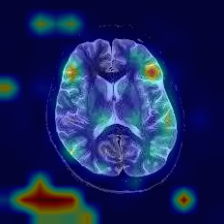

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
from PIL import Image
import cv2
from skimage.filters import threshold_otsu
from transformers import ViTForImageClassification, ViTConfig
from peft import get_peft_model, LoraConfig, TaskType

# Import additional metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- 1. Neuro-Aware Preprocessing Pipeline ---
print("--- 1. Defining Neuro-Aware Preprocessing ---")

class NeuroAwareTransform:
    """
    A custom transform pipeline for brain MRIs.
    1. Converts to grayscale for skull stripping.
    2. Applies Otsu's thresholding to create a mask (simple skull stripping).
    3. Applies the mask to the original color image.
    4. Applies CLAHE for contrast enhancement on the focused brain tissue.
    """
    def __init__(self, output_size=224):
        self.output_size = output_size

    def __call__(self, img):
        # Convert PIL image to OpenCV format
        img_cv = np.array(img)
        img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_RGB2BGR)

        # 1. Grayscale for masking
        gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

        # 2. Otsu's Thresholding for a simple brain mask
        thresh = threshold_otsu(gray)
        mask = gray > thresh

        # 3. Apply mask to original RGB image
        masked_img = img_rgb * mask[:, :, np.newaxis].astype(img_rgb.dtype)

        # 4. Apply CLAHE to the masked image's LAB channels for contrast
        lab = cv2.cvtColor(masked_img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl,a,b))
        final_img_bgr = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

        # Convert back to PIL Image for torchvision transforms
        final_img_pil = Image.fromarray(cv2.cvtColor(final_img_bgr, cv2.COLOR_BGR2RGB))

        return final_img_pil

# Define the full pipeline
data_transform = transforms.Compose([
    NeuroAwareTransform(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# --- 2. The Novel Gated Attention Head ---
print("--- 2. Defining the Gated Attention MLP Head ---")

class GatedAttentionMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # The gating layer
        self.gate_fc = nn.Linear(input_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.silu = nn.SiLU() # Swish activation, works well with gates

    def forward(self, x):
        # Get values and gates
        values = self.silu(self.fc1(x))
        gates = torch.sigmoid(self.gate_fc(x))

        # Element-wise multiplication (gating)
        gated_output = values * gates

        gated_output = self.dropout(gated_output)
        return self.fc2(gated_output)

# --- 3. The Complete NeuroViT Model ---
print("--- 3. Defining the End-to-End NeuroViT Model ---")

class NeuroViT(nn.Module):
    def __init__(self, model_name='google/vit-base-patch16-224-in21k', num_classes=2, k_top_patches=10):
        super().__init__()
        self.k_top_patches = k_top_patches

        # Load ViT config and modify it to output attentions
        config = ViTConfig.from_pretrained(model_name)
        config.output_attentions = True
        self.vit = ViTForImageClassification.from_pretrained(model_name, config=config, ignore_mismatched_sizes=True)

        self.hidden_dim = config.hidden_size

        # Novelty: Fusion dimension is the global CLS token + K flattened patch tokens
        fusion_dim = self.hidden_dim + (self.hidden_dim * self.k_top_patches)

        # Replace the classifier with our new Gated Head
        self.custom_head = GatedAttentionMLP(fusion_dim, self.hidden_dim // 2, num_classes)

    def forward(self, x):
        # Get ViT outputs
        outputs = self.vit.vit(x)
        last_hidden_state = outputs.last_hidden_state
        attentions = outputs.attentions[-1] # Attentions from the last layer

        # --- Attention-Based Feature Selection ---
        # 1. CLS Token (Global representation)
        cls_token = last_hidden_state[:, 0, :]

        # 2. Patch Tokens
        patch_tokens = last_hidden_state[:, 1:, :]

        # 3. Calculate importance score for each patch from attention heads
        # We average the attention given to the CLS token from all patch tokens
        # across all attention heads as a proxy for patch importance.
        attn_scores = attentions[:, :, 0, 1:].mean(dim=1) # Shape: (batch_size, num_patches)

        # 4. Find the top-k most important patches
        top_k_scores, top_k_indices = torch.topk(attn_scores, self.k_top_patches, dim=1)

        # 5. Gather the corresponding patch tokens
        # We need to expand indices to match the hidden dimension
        top_k_indices = top_k_indices.unsqueeze(-1).expand(-1, -1, self.hidden_dim)
        top_patch_tokens = torch.gather(patch_tokens, 1, top_k_indices)

        # --- Global-Local Fusion ---
        # Flatten the top patch tokens
        flat_top_patch_tokens = top_patch_tokens.flatten(start_dim=1)

        # Concatenate CLS token with the important patch tokens
        fused_features = torch.cat([cls_token, flat_top_patch_tokens], dim=1)

        # --- Final Classification ---
        logits = self.custom_head(fused_features)

        # Return logits and the attention map for explainability
        return logits, attn_scores


# --- 4. Configuration and Training Setup ---
print("--- 4. Configuring Training Environment and PEFT (LoRA) ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "/content/sample_data/Train"
LEARNING_RATE = 1e-4
BATCH_SIZE = 16 # Use a smaller batch size due to attention computations
EPOCHS = 10

# Load dataset
dataset = datasets.ImageFolder(root=DATA_DIR, transform=data_transform)
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
class_names = dataset.classes

# Initialize the NeuroViT model
model = NeuroViT(num_classes=len(class_names)).to(device)

# --- LoRA Configuration ---
# This is the key to efficient fine-tuning. We only train the LoRA weights and our new custom head.
lora_config = LoraConfig(
    r=16, # Rank of the update matrices. Higher means more parameters.
    lora_alpha=32, # Alpha scaling factor.
    target_modules=["query", "value"], # Apply LoRA to query and value matrices in attention blocks
    lora_dropout=0.1,
    bias="none",
    # THE FIX: Use SEQ_CLS for Vision Transformer classification tasks
    task_type=TaskType.SEQ_CLS,
)

# Make the ViT part of our model tunable with LoRA
model.vit = get_peft_model(model.vit, lora_config)
model.vit.print_trainable_parameters()

# Optimizer and Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- 5. Training and Validation Loop ---
print("\n--- 5. Starting End-to-End Training of NeuroViT ---")

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, _ = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (logits.argmax(dim=1) == labels).sum().item()

    # Validation (per epoch)
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits, _ = model(images)
            val_loss += criterion(logits, labels).item()
            val_correct += (logits.argmax(dim=1) == labels).sum().item()

    print(f"Train Acc: {total_correct/len(train_data):.4f} | Val Acc: {val_correct/len(val_data):.4f}")

# --- 6. Final Model Evaluation ---
print("\n--- 6. Performing Final Model Evaluation on Validation Set ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Final Evaluation"):
        images, labels = images.to(device), labels.to(device)
        logits, _ = model(images)
        predictions = logits.argmax(dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print comprehensive metrics
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# You can also print individual metrics if desired
final_accuracy = accuracy_score(all_labels, all_preds)
final_precision = precision_score(all_labels, all_preds, average='weighted') # Use weighted for multi-class
final_recall = recall_score(all_labels, all_preds, average='weighted') # Use weighted for multi-class
final_f1 = f1_score(all_labels, all_preds, average='weighted') # Use weighted for multi-class

print(f"\nFinal Accuracy: {final_accuracy:.4f}")
print(f"Final Precision (weighted): {final_precision:.4f}")
print(f"Final Recall (weighted): {final_recall:.4f}")
print(f"Final F1-Score (weighted): {final_f1:.4f}")


# --- 7. Explainability: Visualize Attention on a Test Image ---
# (Renumbered from 6 to 7)
print("\n--- 7. Generating Explainability Overlay ---")
model.eval()
with torch.no_grad():
    # Get a sample image from the validation set
    # Ensure val_data is accessible and has at least one element
    if len(val_data) > 0:
        img_tensor, label = val_data[0]
        img_tensor = img_tensor.unsqueeze(0).to(device)

        # Get the prediction and the attention map
        logits, attn_map = model(img_tensor)
        pred_label = class_names[logits.argmax(dim=1).item()]

        # Reshape attention map to a 2D grid (14x14 for ViT-B16)
        # Assuming a 224x224 input and 16x16 patches, num_patches_side will be 14
        num_patches_side = int(np.sqrt(attn_map.shape[1]))
        attn_heatmap = attn_map.reshape((num_patches_side, num_patches_side)).cpu().numpy()

        # Upscale heatmap to image size and overlay
        heatmap_resized = cv2.resize(attn_heatmap, (224, 224))
        heatmap_normalized = (heatmap_resized - heatmap_resized.min()) / (heatmap_resized.max() - heatmap_normalized.min())
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_normalized), cv2.COLORMAP_JET)

        # Superimpose heatmap on original image
        original_img_np = np.transpose(val_data[0][0].numpy(), (1, 2, 0))
        # Un-normalize for visualization (assuming mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
        original_img_np = (original_img_np * 0.5) + 0.5
        original_img_np = np.uint8(255 * original_img_np)

        superimposed_img = cv2.addWeighted(cv2.cvtColor(original_img_np, cv2.COLOR_RGB2BGR), 0.6, heatmap_colored, 0.4, 0)

        # Display using Pillow
        print(f"Sample Image - True Label: {class_names[label]}, Predicted: {pred_label}")
        from IPython.display import display # Ensure display is imported for Colab/Jupyter
        display(Image.fromarray(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)))
    else:
        print("Validation data is empty. Cannot generate explainability overlay.")

